In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [173]:
train = pd.read_csv('../data/raw/train.csv')

In [174]:
test = pd.read_csv('../data/raw/test.csv')

In [175]:
sample_submission = pd.read_csv("../data/raw/sample_submission.csv")

In [176]:
train = train[(train['full_sq'] > 8) & (train['full_sq'] < 600)]
train = train[(train['price_doc'] > 2000000) & (train['price_doc'] < 1000000000)]
train = train[(train['kremlin_km'] > 0.5)]

In [177]:
train['price_m2'] = train['price_doc'] / train['full_sq']

In [178]:
features = ['metro_km_walk', 'kremlin_km']
kf = KFold(n_splits = 5, shuffle = True) #random_state=42)
target = "price_m2"

msle_list = []
mse_list = []
for i, (train_index, val_index) in enumerate(kf.split(train)):    
    train_part = train.iloc[train_index, : ]
    val_part = train.iloc[val_index, :]
    model = SGDRegressor()
    model.fit(X = train_part[features].fillna(0), y = train_part[target])

    val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

    mse = mean_squared_error(val_predication, val_part[target])
    msle = mean_squared_log_error(val_predication, val_part[target])

    pirce_mse = mean_squared_error(val_predication * val_part['full_sq'], val_part['price_doc'])
    pirce_msle = mean_squared_log_error(val_predication * val_part['full_sq'], val_part['price_doc'])

    print(f'Fold full {i}: msle {pirce_msle}, mse {pirce_mse}')
    msle_list.append(pirce_msle)
    mse_list.append(pirce_mse)

print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')

Fold full 0: msle 0.402220516343981, mse 8819287658575.96
Fold full 1: msle 0.3293709207332199, mse 8220208523759.83
Fold full 2: msle 0.08800044146599709, mse 8355452738813.445
Fold full 3: msle 0.509672438910963, mse 10119398401727.234
Fold full 4: msle 0.4526347704816159, mse 9865893451303.34
MSLE average = 0.35637981758715537, std = 0.1467119513931989


Среднее значение MSLE = 0.9366931275921726 \
Score kaggle = 1.78789

Добавляем в признаки расстояние до кремля:\
Среднее значение MSLE = 0.2602684439292855\
Score kaggle = 0.37913\
Добавляем в признаки наличие большой церкви в радиусе 500 метров:\
Среднее значение MSLE = 0.20219538049012628\
Score kaggle = 0.39429

In [179]:
train = train[(train['metro_km_walk'] > 0.0) & (train['metro_km_walk'] < 5)]

In [180]:
features = ['metro_km_walk', 'kremlin_km']
kf = KFold(n_splits = 5, shuffle = True) #random_state=42)
target = "price_m2"

msle_list = []
mse_list = []
for i, (train_index, val_index) in enumerate(kf.split(train)):    
    train_part = train.iloc[train_index, : ]
    val_part = train.iloc[val_index, :]
    model = SGDRegressor()
    model.fit(X = train_part[features].fillna(0), y = train_part[target])

    val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

    mse = mean_squared_error(val_predication, val_part[target])
    msle = mean_squared_log_error(val_predication, val_part[target])

    pirce_mse = mean_squared_error(val_predication * val_part['full_sq'], val_part['price_doc'])
    pirce_msle = mean_squared_log_error(val_predication * val_part['full_sq'], val_part['price_doc'])

    print(f'Fold full {i}: msle {pirce_msle}, mse {pirce_mse}')
    msle_list.append(pirce_msle)
    mse_list.append(pirce_mse)

print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')

Fold full 0: msle 0.09267855350625072, mse 10491696870967.137
Fold full 1: msle 0.08083965519622174, mse 11575768047449.855
Fold full 2: msle 0.07747100514746956, mse 9381357928935.611
Fold full 3: msle 0.08571439531468157, mse 11239400296355.695
Fold full 4: msle 0.07718225598354242, mse 6879615148878.9
MSLE average = 0.08277717302963321, std = 0.005828843792651454


Мы убрали те квартиры, которые находятся на расстоянии 0.0 от станции метро и убрали квартиры которые дальше чем, за 5 км от ближайшей станции метро, так как для них расстояние до кремля уже не является весомым признаком. Для признака 'kremlin_km' ограничили минимальное расстоние до 300 метров.

Среднее значение MSLE = 0.10350537460888302 \
Score kaggle = 4.16866\
Добавили расстояние до кремля:\
Среднее значение MSLE = 0.08428154524559651 \
Score kaggle = 3.48156

<AxesSubplot:>

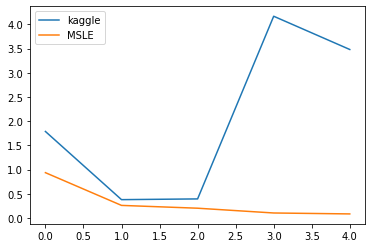

In [181]:
result = [(0.9366931275921726, 1.78789), (0.2602684439292855, 0.37913), (0.20219538049012628, 0.39429), (0.10350537460888302, 4.16866), (0.08428154524559651, 3.48156)]
df = pd.DataFrame({"kaggle":[item[1] for item in result], "MSLE":[item[0] for item in result]})
df.plot()


In [143]:
target = "price_m2"

model = SGDRegressor()
model.fit(X = train[features].fillna(0.0), y = train[target])

test[target] = model.predict(test[features].fillna(0))
sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
sample_submission['price_doc'] = (test[target] * test['full_sq']).clip(0, 100000000)
sample_submission.to_csv('_twoFeat_new_model.csv', index = False)